### Imports

In [19]:
import numpy as np # math

from astropy.table import Table # data stuffs
from astropy.cosmology import Planck18 as cosmo # cosmology for radius calc

import astropy.units as u # units for conversion and stuff
import matplotlib.pyplot as plt # plots

# Load Data required

### Matched Cluster

Load in matched Cluster-Quasars that was produced in another notebook

In [20]:
quasar_matches = Table.read("../Products/Tables/Cluster_Quasar_Matches_300kpc.csv")
print(f"{len(quasar_matches)} Cluster-Quasar Matches")
quasar_matches[0:3]

138 Cluster-Quasar Matches


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,QUAIA_source_id,QUAIA_redshift,QUAIA_redshift_err,CLUSTER_NAME,SEPARATION,CLUSTER_Z
str23,int64,float64,float64,float64,float64,float64,int64,float64,float64,str23,float64,float64
1eRASS J034542.8-512950,105814100004,56.428536351919384,-51.49737416405309,0.8932768702507019,0.0,1.2494709043450736e-12,4829294973181982976,0.396,0.07660170276641848,1eRASS J034542.1-513042,0.014563502373970234,0.1939
1eRASS J043829.2-614758,107315300001,69.62171465309667,-61.79967048220355,0.3404570519924164,0.0,4.316204078175234e-12,4677239112130585984,1.927,0.7133141228485108,1eRASS J043838.1-615107,0.055282362612759095,0.0659
1eRASS J045957.6-611510,107715000001,74.99019789325905,-61.25294175144008,0.35830843448638916,0.0,2.8914154057146924e-12,4761465310590509056,0.16512604357212446,0.09792351691246033,1eRASS J045949.0-611349,0.028276261080173008,0.093


### eRASS Clusters

Load in eRASS cluster data for checking flux <rb>
This table can be downloaded from the [eROSITA DR1 Website](https://erosita.mpe.mpg.de/dr1/AllSkySurveyData_dr1/Catalogues_dr1/)

In [21]:
clusters_table = Table.read("../Data/erass1cl_primary_v3.2.fits")
print(f"{len(clusters_table)} Cluster")
clusters_table[0:3]


12247 Cluster


DETUID,NAME,RA,DEC,RA_XFIT,DEC_XFIT,EXT_LIKE,DET_LIKE_0,EXP,BEST_Z,BEST_ZERR,BEST_Z_TYPE,PCONT,CR300kpc,CR300kpc_L,CR300kpc_H,CR500,CR500_L,CR500_H,CTS300kpc,CTS300kpc_L,CTS300kpc_H,CTS500,CTS500_L,CTS500_H,F300kpc,F300kpc_L,F300kpc_H,F500,F500_L,F500_H,L300kpc,L300kpc_L,L300kpc_H,L500,L500_L,L500_H,CR300kpc0520,CR300kpc_L0520,CR300kpc_H0520,CR500_0520,CR500_L_0520,CR500_H_0520,CTS300kpc0520,CTS300kpc_L0520,CTS300kpc_H0520,CTS500_0520,CTS500_L_0520,CTS500_H_0520,F300kpc0520,F300kpc_L0520,F300kpc_H0520,F500_0520,F500_L_0520,F500_H_0520,L300kpc0520,L300kpc_L0520,L300kpc_H0520,L500_0520,L500_L_0520,L500_H_0520,Lbol500,Lbol500_L,Lbol500_H,KT,KT_L,KT_H,MGAS500,MGAS500_L,MGAS500_H,YX500,YX500_L,YX500_H,M500,M500_L,M500_H,FGAS500,FGAS500_L,FGAS500_H,R500,R500_L,R500_H,MATCH_NAME,M500_PDF,M500_PDF_array
,,deg,deg,deg,deg,,,,,,,,1 / s,1 / s,1 / s,1 / s,1 / s,1 / s,,,,,,,1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1 / s,1 / s,1 / s,1 / s,1 / s,1 / s,,,,,,,1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,keV,keV,keV,1e+11 solMass,1e+11 solMass,1e+11 solMass,1e+11 keV solMass,1e+11 keV solMass,1e+11 keV solMass,1e+13 solMass,1e+13 solMass,1e+13 solMass,,,,kpc,kpc,kpc,,,solMass
bytes32,bytes23,float64,float64,float64,float64,float32,float32,float32,float64,float64,bytes16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes240,float64[200],float64[200]
em01_002129_020_ML00014_002_c010,1eRASS J000005.2-383729,0.021729666982255817,-38.6249030550687,0.0214,-38.625,9.634506,80.58653,94.8,0.3153,0.0079,photo_z,0.006,0.352,0.287,0.434,0.509,0.404,0.627,33.4,27.2,41.1,48.2,38.3,59.4,32.51,26.686,39.709,47.11,37.15,57.854,97.485,78.312,119.878,140.172,111.091,173.67,0.276,0.225,0.339,0.4,0.316,0.49,26.1,21.3,32.2,37.9,30.0,46.4,23.137,19.103,28.383,33.653,26.557,41.195,66.955,53.625,82.239,96.23,76.158,119.632,253.286,196.126,349.587,1.9,1.37,3.53,279.16,209.64,328.65,553.19,348.81,964.03,36.07,29.45,44.96,0.075,0.054,0.102,971.0,908.0,1045.0,"ACTDR5_ACT-CL J0000.0-3837,SPTECS_J0000-3838",5.851765968674475e-18 .. 3.9392481575469995e-11,999999999999.999 .. 9999999999999964.0
em01_011174_020_ML00047_002_c010,1eRASS J000021.4-824954,0.08919076582988208,-82.83171519254894,0.0558,-82.8189,14.928127,37.221573,184.2,0.0891,0.0002,cg_spec_z,0.0,0.699,0.628,0.774,1.029,0.926,1.149,128.8,115.6,142.6,189.5,170.6,211.6,66.773,60.058,74.071,98.355,88.515,109.715,16.881,15.108,18.682,24.747,22.321,27.683,0.603,0.541,0.668,0.887,0.799,0.99,111.0,99.6,123.0,163.3,147.1,182.4,53.122,47.819,58.881,78.328,70.466,87.401,11.653,10.43,12.911,17.115,15.439,19.131,76.492,53.559,123.554,-1.0,3.82,-1.0,111.92,96.52,125.58,-0.0,-0.0,-0.0,16.99,15.65,18.85,0.065,0.055,0.076,819.0,796.0,847.0,,4.8286962310633425e-14 .. 7.862194469501027e-15,999999999999.999 .. 9999999999999964.0
em01_002141_020_ML00031_002_c010,1eRASS J000031.0-500903,0.1294219086203196,-50.151012746035505,0.1305,-50.1515,6.9752207,46.228764,117.3,0.0681,0.0002,cg_spec_z,0.218,0.255,0.178,0.396,0.258,0.18,0.493,29.9,20.9,46.5,30.3,21.1,57.8,23.888,17.01,37.288,23.991,17.1,45.932,2.816,1.984,4.374,2.862,1.996,5.454,0.203,0.143,0.318,0.206,0.144,0.393,23.8,1

Select Required columns
- NAME
- RA
- DEC
- BEST_Z
- R500
- F300kpc0520
- MATCH_NAME

Also remove clusters not matched for sake of efficiency

In [22]:
clusters_table = clusters_table['NAME', 'RA', 'DEC', 'BEST_Z', 'R500', 'F300kpc0520', 'MATCH_NAME']

removal_cond = np.isin(clusters_table['NAME'], np.unique(quasar_matches['CLUSTER_NAME']))

clusters_table = clusters_table[removal_cond]
print(f"{len(clusters_table)} Matched Clusters")
clusters_table[:3]

104 Matched Clusters


NAME,RA,DEC,BEST_Z,R500,F300kpc0520,MATCH_NAME
,deg,deg,,kpc,1e-14 erg / (s cm2),
bytes23,float64,float64,float64,float64,float64,bytes240
1eRASS J001838.2-415336,4.659310615568812,-41.89338866960187,0.093,761.0,24.241,
1eRASS J012335.2-353449,20.89673790303013,-35.580394939283785,0.2374,618.0,6.574,
1eRASS J012604.4-375757,21.518639967549184,-37.966094933259555,0.0806,887.0,84.275,"ABELL_A2911,MARDY3_MARDJ012605.9-375758,MCXC_J0126.0-3758"


Convert the flux units to $erg s^{-1} cm^{-2}$

In [23]:
clusters_table['F300kpc0520'] = u.Quantity(clusters_table['F300kpc0520'], "erg/(s cm2)")
clusters_table[:3]

NAME,RA,DEC,BEST_Z,R500,F300kpc0520,MATCH_NAME
,deg,deg,,kpc,erg / (s cm2),
bytes23,float64,float64,float64,float64,float64,bytes240
1eRASS J001838.2-415336,4.659310615568812,-41.89338866960187,0.093,761.0,2.4240999999999997e-13,
1eRASS J012335.2-353449,20.89673790303013,-35.580394939283785,0.2374,618.0,6.573999999999999e-14,
1eRASS J012604.4-375757,21.518639967549184,-37.966094933259555,0.0806,887.0,8.4275e-13,"ABELL_A2911,MARDY3_MARDJ012605.9-375758,MCXC_J0126.0-3758"


Add cluster flux values to Cluster-Quasar Table
(Will also add Cluster R500 value because it is convenient to add it here although not used)

In [24]:
# loops aren't efficient but not too many quasar-cluster matches and this was so much simpler than messing with array logic
quasar_matches["CLUSTER_FLUX"] = np.zeros(len(quasar_matches))
quasar_matches["CLUSTER_R500"] = np.zeros(len(quasar_matches), dtype=float)

for quasar in quasar_matches:
    quasar["CLUSTER_FLUX"] = clusters_table[clusters_table["NAME"]==quasar["CLUSTER_NAME"]]["F300kpc0520"]
    quasar["CLUSTER_R500"] = clusters_table[clusters_table["NAME"]==quasar["CLUSTER_NAME"]]["R500"]

quasar_matches[:3]

IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,QUAIA_source_id,QUAIA_redshift,QUAIA_redshift_err,CLUSTER_NAME,SEPARATION,CLUSTER_Z,CLUSTER_FLUX,CLUSTER_R500
str23,int64,float64,float64,float64,float64,float64,int64,float64,float64,str23,float64,float64,float64,float64
1eRASS J034542.8-512950,105814100004,56.428536351919384,-51.49737416405309,0.8932768702507019,0.0,1.2494709043450736e-12,4829294973181982976,0.396,0.07660170276641848,1eRASS J034542.1-513042,0.014563502373970234,0.1939,2.4678e-13,891.0
1eRASS J043829.2-614758,107315300001,69.62171465309667,-61.79967048220355,0.3404570519924164,0.0,4.316204078175234e-12,4677239112130585984,1.927,0.7133141228485108,1eRASS J043838.1-615107,0.055282362612759095,0.0659,2.3504000000000003e-13,598.0
1eRASS J045957.6-611510,107715000001,74.99019789325905,-61.25294175144008,0.35830843448638916,0.0,2.8914154057146924e-12,4761465310590509056,0.16512604357212446,0.09792351691246033,1eRASS J045949.0-611349,0.028276261080173008,0.093,5.5426e-13,798.0


quasar separation in kpc

In [25]:
quasar_matches["SEPARATION_R"] = u.Quantity(cosmo.kpc_proper_per_arcmin(quasar_matches["CLUSTER_Z"])*u.Quantity(quasar_matches["SEPARATION"], 'deg'), "kpc")
quasar_matches[:3]

IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,QUAIA_source_id,QUAIA_redshift,QUAIA_redshift_err,CLUSTER_NAME,SEPARATION,CLUSTER_Z,CLUSTER_FLUX,CLUSTER_R500,SEPARATION_R
,,,,,,,,,,,,,,,kpc
str23,int64,float64,float64,float64,float64,float64,int64,float64,float64,str23,float64,float64,float64,float64,float64
1eRASS J034542.8-512950,105814100004,56.428536351919384,-51.49737416405309,0.8932768702507019,0.0,1.2494709043450736e-12,4829294973181982976,0.396,0.07660170276641848,1eRASS J034542.1-513042,0.014563502373970234,0.1939,2.4678e-13,891.0,174.39308805364402
1eRASS J043829.2-614758,107315300001,69.62171465309667,-61.79967048220355,0.3404570519924164,0.0,4.316204078175234e-12,4677239112130585984,1.927,0.7133141228485108,1eRASS J043838.1-615107,0.055282362612759095,0.0659,2.3504000000000003e-13,598.0,260.20071499975273
1eRASS J045957.6-611510,107715000001,74.99019789325905,-61.25294175144008,0.35830843448638916,0.0,2.8914154057146924e-12,4761465310590509056,0.16512604357212446,0.09792351691246033,1eRASS J045949.0-611349,0.028276261080173008,0.093,5.5426e-13,798.0,181.95463926000983


Rough plot of Cluster flux vs Quasar Flux

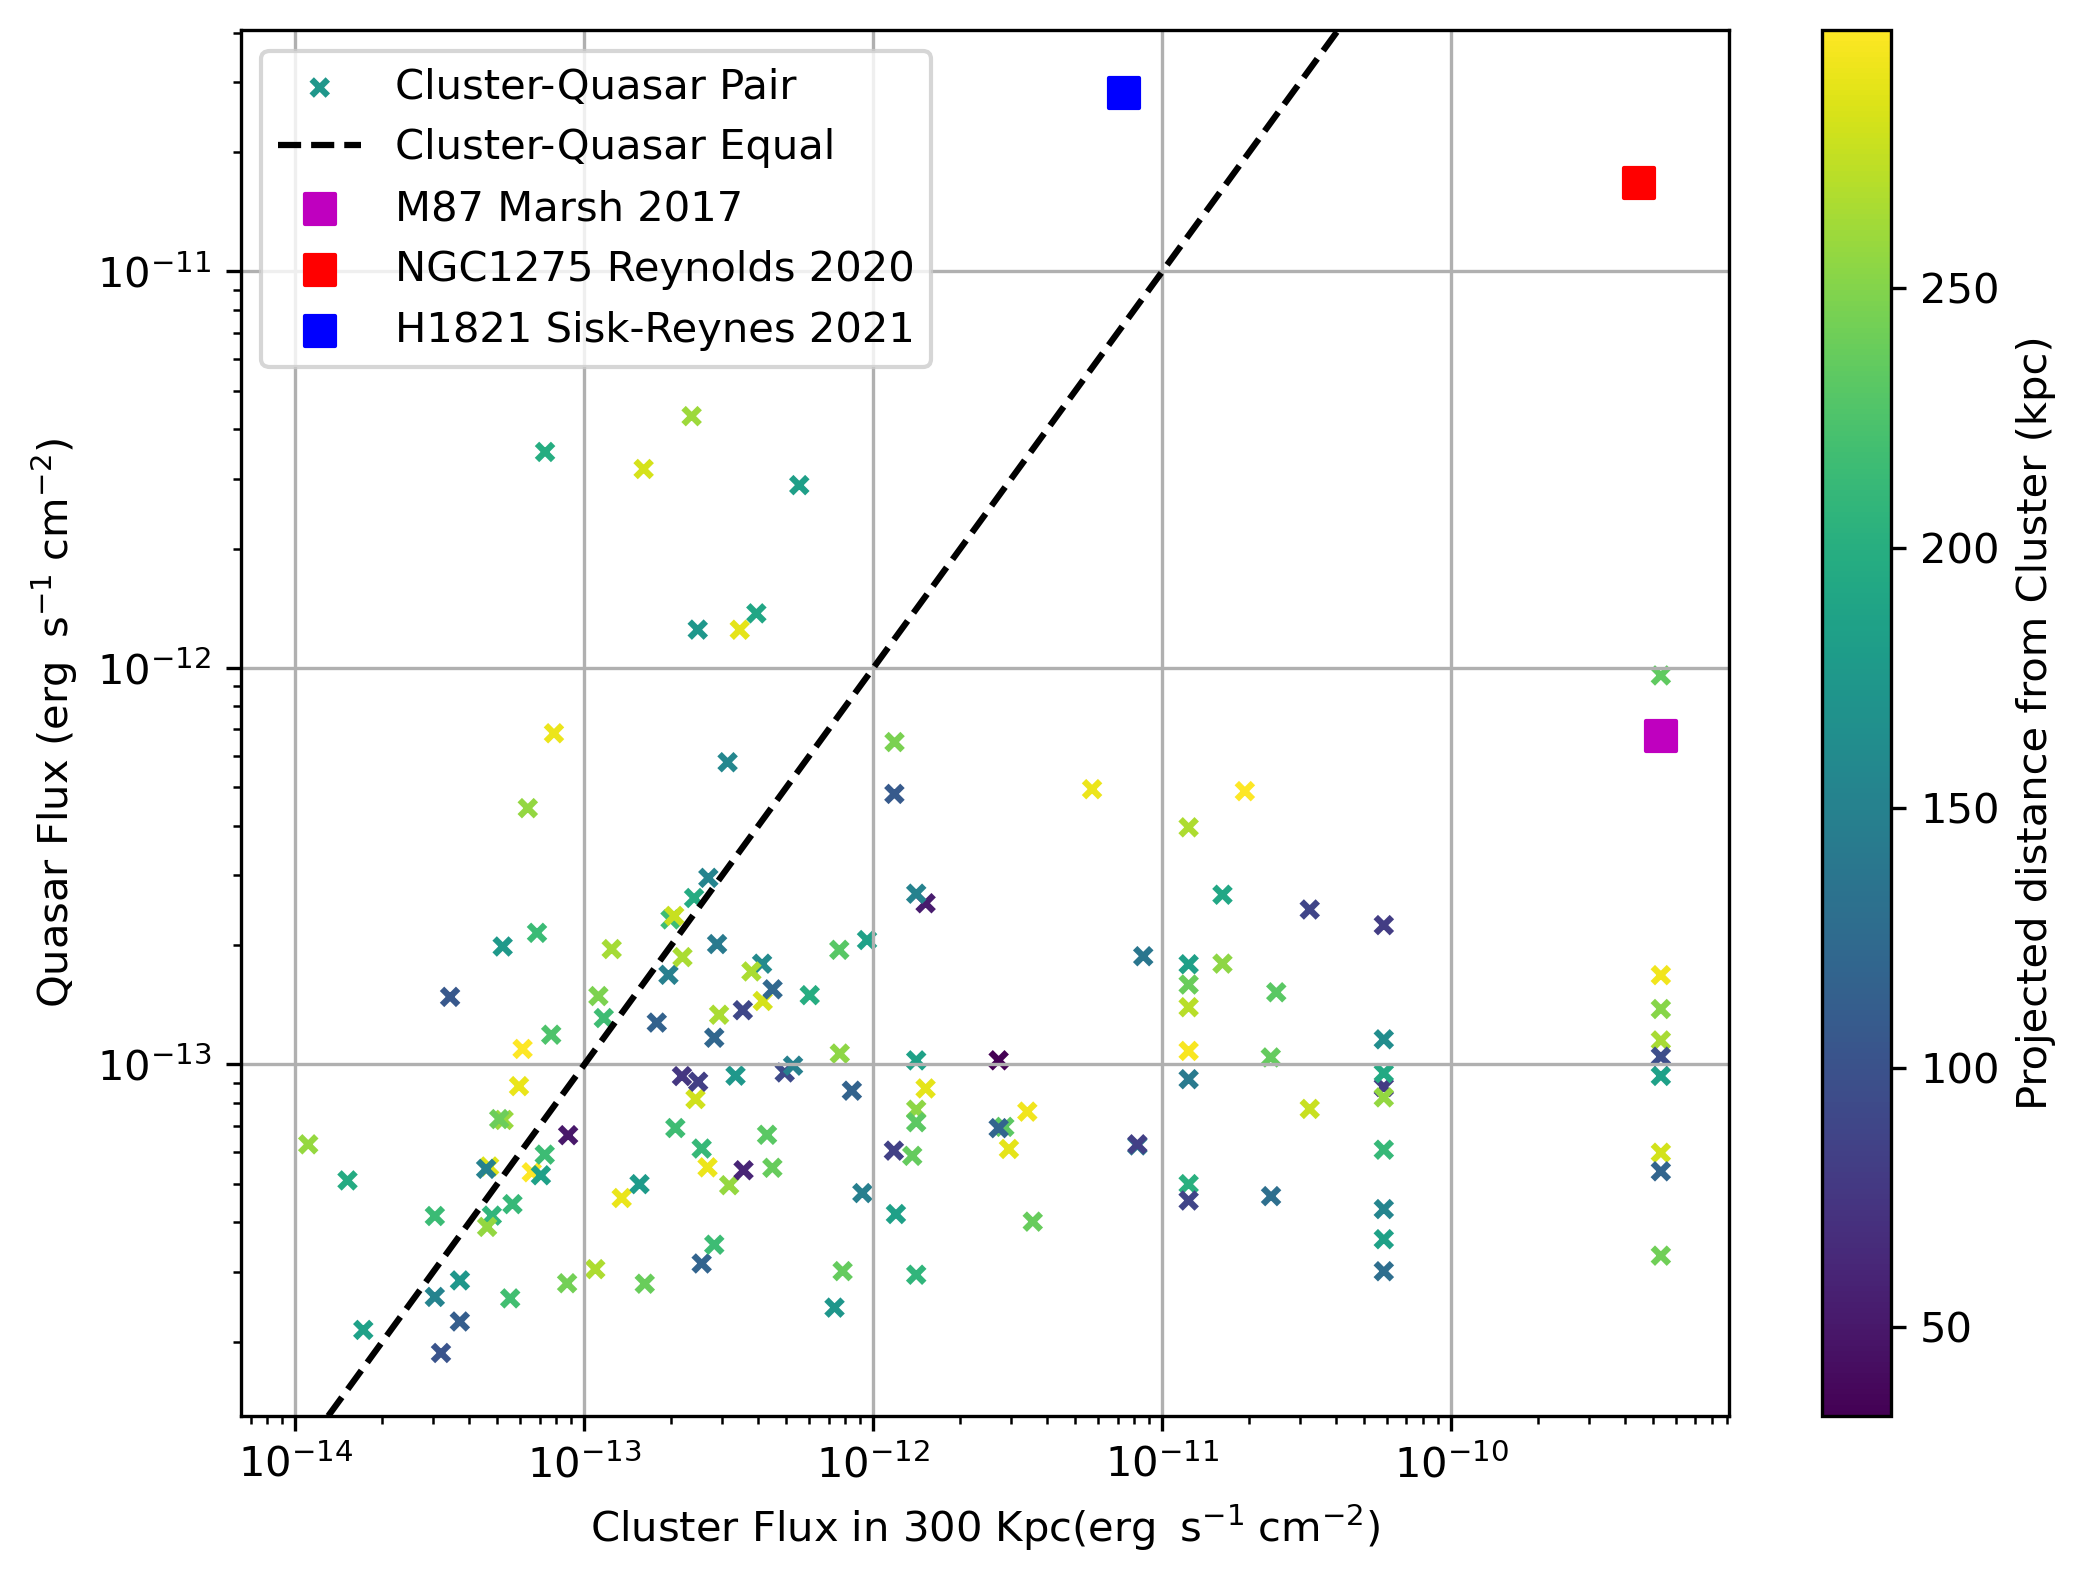

In [26]:
plt.figure(dpi=300, figsize=(8, 6))
plt.scatter(quasar_matches["CLUSTER_FLUX"], quasar_matches["ML_FLUX_1"], marker='x', c=quasar_matches["SEPARATION_R"], s=15, label="Cluster-Quasar Pair")
plt.axline((0,0), slope=1, c='k', ls='--', label="Cluster-Quasar Equal")

# for some reason color bar has to go here or it has wrong values...
plt.colorbar(label="Projected distance from Cluster (kpc)")

# # plot examples from literature
plt.scatter(5.32e-10, 6.73e-13, marker=',', s=50, c='m',label="M87 Marsh 2017")
plt.scatter(4.45e-10, 1.67e-11, marker=',', s=50, c='r', label="NGC1275 Reynolds 2020")
plt.scatter(7.39e-12, 2.82e-11, marker=',', s=50, c='b', label="H1821 Sisk-Reynes 2021")

plt.loglog()
plt.grid()
plt.xlabel(r"Cluster Flux in 300 Kpc($\rm{erg} \;\; \rm{s}^{-1} \; \rm{cm}^{-2}$)")
plt.ylabel(r"Quasar Flux ($\rm{erg} \;\; \rm{s}^{-1} \; \rm{cm}^{-2}$)")

plt.legend()

plt.savefig("Quasar_Cluster_Comparision.png", dpi=400)
plt.show()


In [27]:
# quasar_matches.sort(["CLUSTER_FLUX", "ML_FLUX_1"], reverse=True)
# quasar_matches

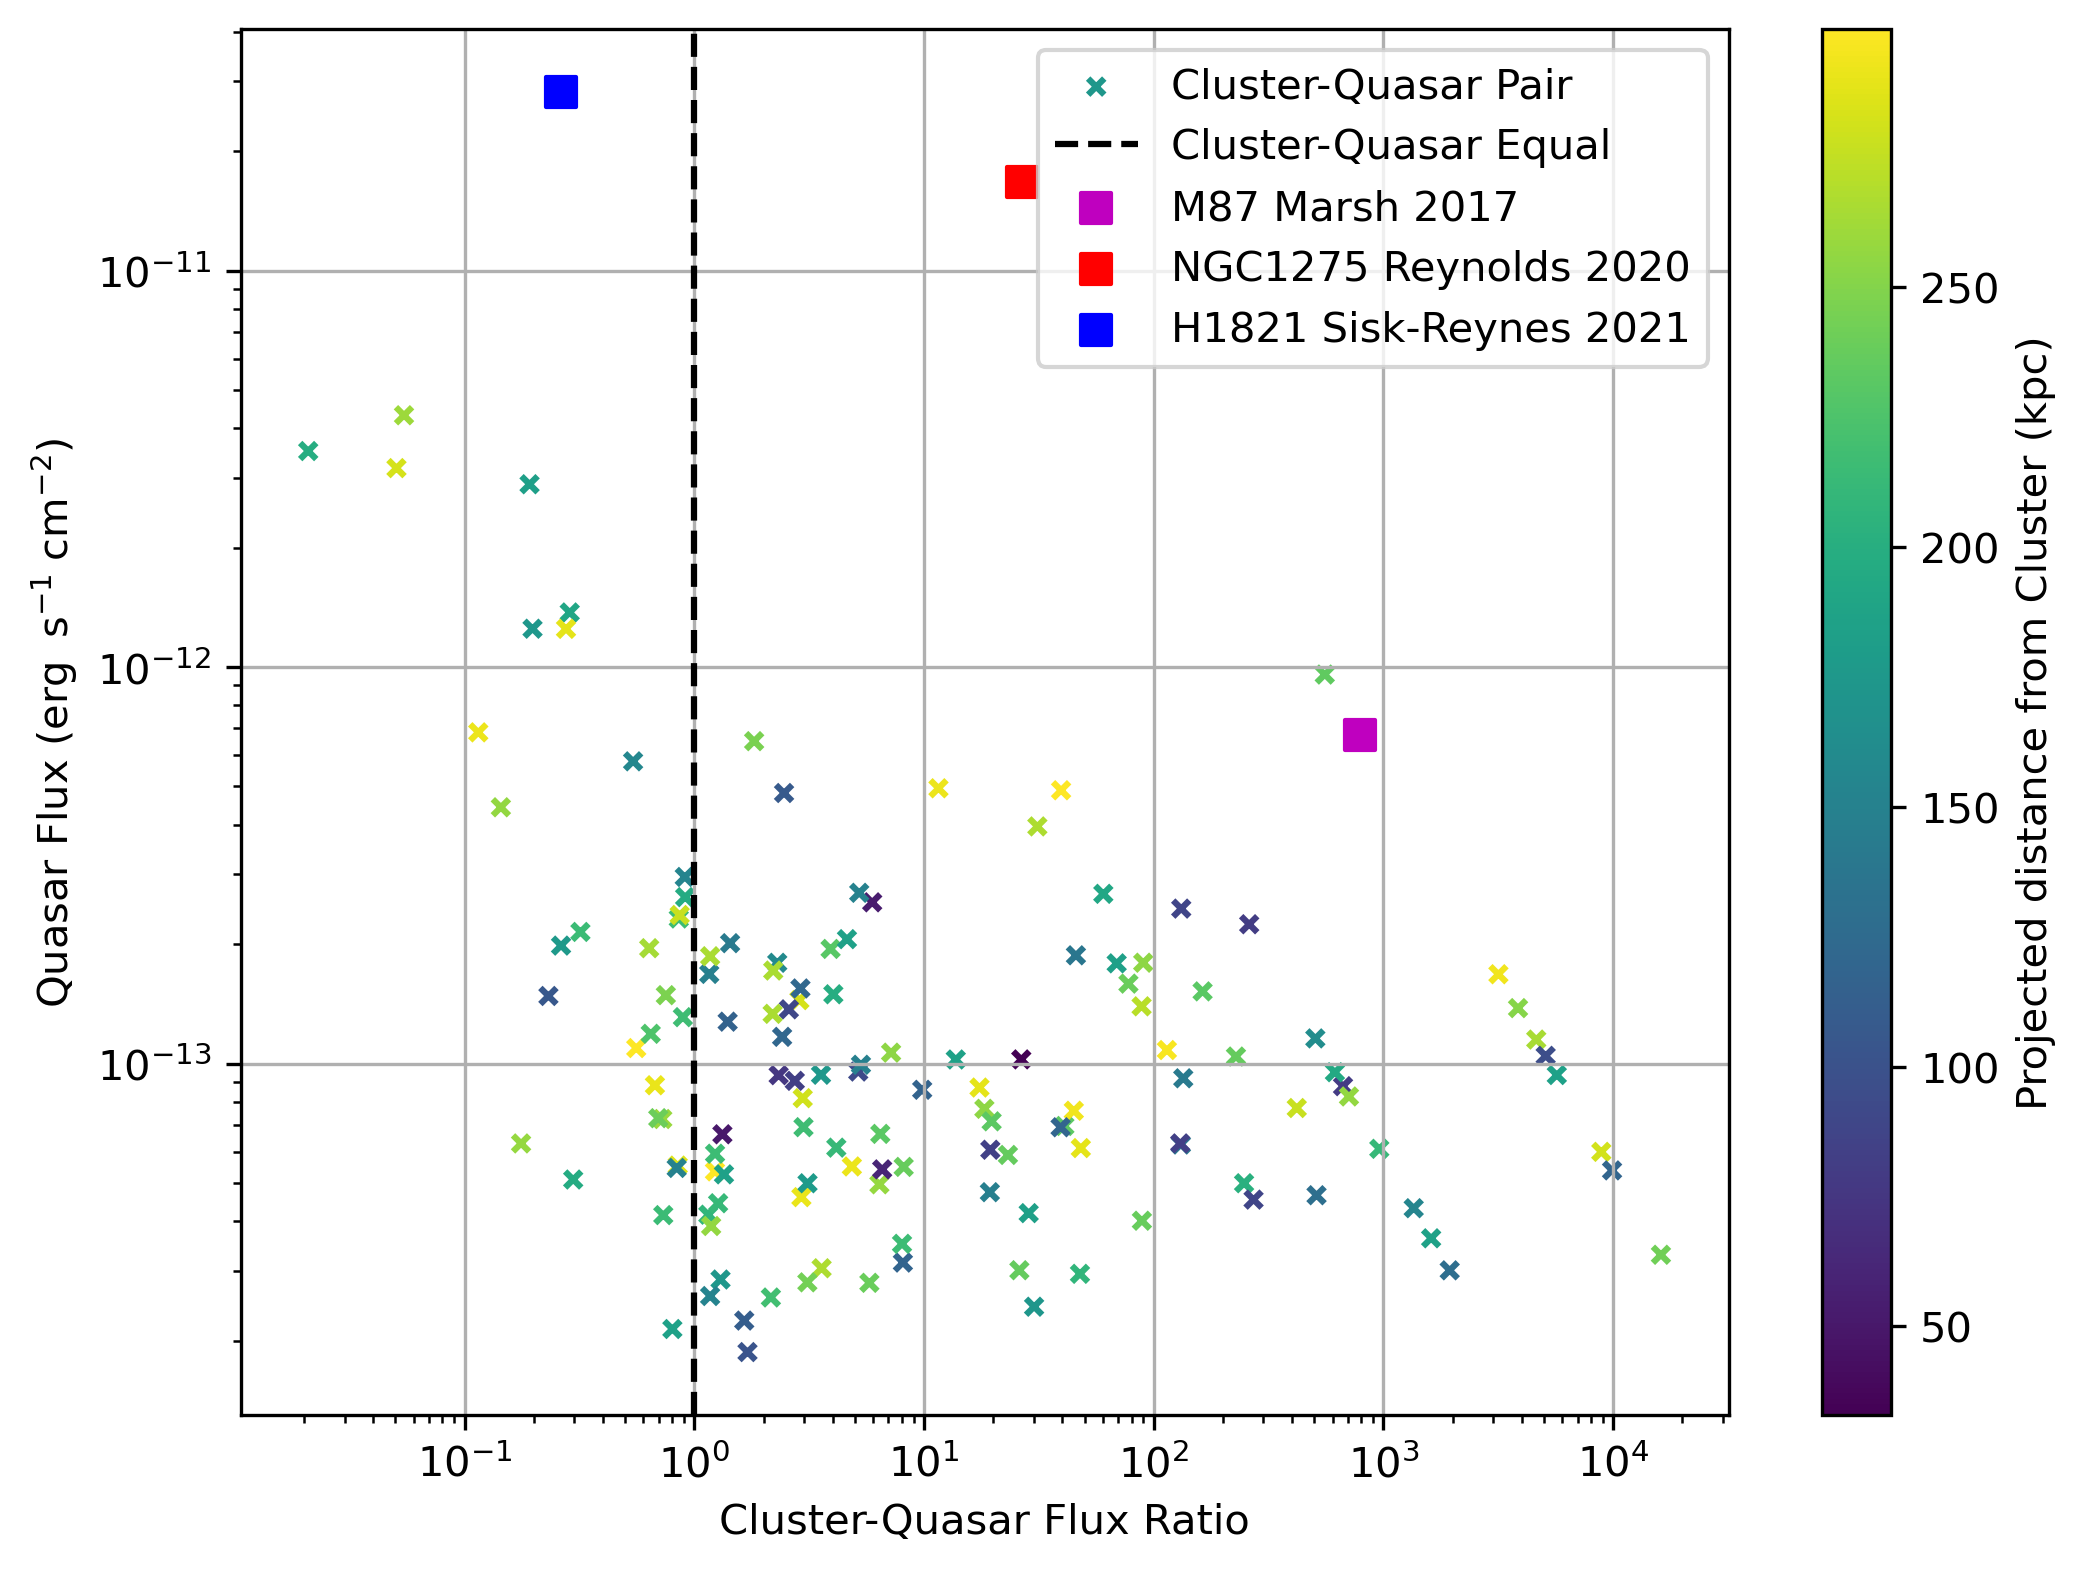

In [28]:
plt.figure(dpi=300, figsize=(8, 6))
plt.scatter(quasar_matches["CLUSTER_FLUX"]/quasar_matches["ML_FLUX_1"], quasar_matches["ML_FLUX_1"], marker='x', c=quasar_matches["SEPARATION_R"], s=15, label="Cluster-Quasar Pair")
# plt.axline((0,0), slope=1, c='k', ls='--', label="Cluster-Quasar Equal")
plt.axvline(1, c='k', ls='--', label="Cluster-Quasar Equal")

# for some reason color bar has to go here or it has wrong values...
plt.colorbar(label="Projected distance from Cluster (kpc)")

# # plot examples from literature
plt.scatter(5.32e-10/6.73e-13, 6.73e-13, marker=',', s=50, c='m',label="M87 Marsh 2017")
plt.scatter(4.45e-10/1.67e-11, 1.67e-11, marker=',', s=50, c='r', label="NGC1275 Reynolds 2020")
plt.scatter(7.39e-12/2.82e-11, 2.82e-11, marker=',', s=50, c='b', label="H1821 Sisk-Reynes 2021")

plt.loglog()

plt.grid()
plt.xlabel(r"Cluster-Quasar Flux Ratio")
plt.ylabel(r"Quasar Flux ($\rm{erg} \;\; \rm{s}^{-1} \; \rm{cm}^{-2}$)")

plt.legend()

plt.show()

Going to remove all quasars with a flux less than $10^{-13} \; \rm{erg} \; \rm{s}^{-1} \; \rm{cm}^{-2}$ since these will probably not be bright enough.<br><br>
Will also remove all pairs with a cluster/quasar flux ratio higher than NGC1275 Reynolds 2020 since these will probably bit too faint compared to cluster so not usuable either.<br>
I will note that this would also exclude M87 Marsh 2017 however this is fine since to get better constaints, cluster must be easily subtractable from the quasar.

In [29]:
quasar_matches_reduced = quasar_matches[quasar_matches["ML_FLUX_1"] > 1e-13]
quasar_matches_reduced = quasar_matches_reduced[quasar_matches_reduced["CLUSTER_FLUX"]/quasar_matches_reduced["ML_FLUX_1"] < 4.45e-10/1.67e-11]
print(f"{len(quasar_matches_reduced)} remaining pairs")
quasar_matches_reduced

44 remaining pairs


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,QUAIA_source_id,QUAIA_redshift,QUAIA_redshift_err,CLUSTER_NAME,SEPARATION,CLUSTER_Z,CLUSTER_FLUX,CLUSTER_R500,SEPARATION_R
,,,,,,,,,,,,,,,kpc
str23,int64,float64,float64,float64,float64,float64,int64,float64,float64,str23,float64,float64,float64,float64,float64
1eRASS J034542.8-512950,105814100004,56.428536351919384,-51.49737416405309,0.8932768702507019,0.0,1.2494709043450736e-12,4829294973181982976,0.396,0.07660170276641848,1eRASS J034542.1-513042,0.014563502373970234,0.1939,2.4678e-13,891.0,174.39308805364402
1eRASS J043829.2-614758,107315300001,69.62171465309667,-61.79967048220355,0.3404570519924164,0.0,4.316204078175234e-12,4677239112130585984,1.927,0.7133141228485108,1eRASS J043838.1-615107,0.055282362612759095,0.0659,2.3504000000000003e-13,598.0,260.20071499975273
1eRASS J045957.6-611510,107715000001,74.99019789325905,-61.25294175144008,0.35830843448638916,0.0,2.8914154057146924e-12,4761465310590509056,0.16512604357212446,0.09792351691246033,1eRASS J045949.0-611349,0.028276261080173008,0.093,5.5426e-13,798.0,181.95463926000983
1eRASS J051621.0-103341,107810200002,79.08789664207139,-10.561521945751187,0.6047040820121765,0.0,3.5063143794672458e-12,2990073016486189056,0.3115370273590088,0.16922684105873104,1eRASS J051626.6-103259,0.025458278986997852,0.1155,7.309000000000001e-14,597.0,198.24560383386685
1eRASS J060241.8-595152,108915000003,90.67454848061813,-59.86446695258894,0.7766640782356262,0.0,5.784297736968758e-13,5494423607324927872,0.1011425331234932,0.05274107449054718,1eRASS J060232.1-595106,0.02398260881687685,0.0947,3.1304e-13,719.0,156.83681151563093
1eRASS J062307.4-643619,109315600002,95.78120338450204,-64.6054644793165,0.8028334975242615,0.0,3.175580891995322e-12,5476948725428677376,0.16680968912865757,0.14097615360975266,1eRASS J062238.2-643200,0.0889746292682517,0.0432,1.6035e-13,473.0,282.04050370109724
1eRASS J234931.6-363458,135812600026,357.38179902077394,-36.58289509104878,2.9871714115142822,0.0,2.147584004076955e-13,2310821636519890432,0.5941154360771179,0.12225273481365201,1eRASS J234950.8-363449,0.06432233043857426,0.0456,6.855000000000001e-14,322.0,214.605253835957
1eRASS J023010.7-141748,103810500065,37.54469911739319,-14.296729798518534,2.7968251705169678,0.0,1.4456018576202573e-13,5146274760900681344,1.8980954885482788,0.4301327623748781,1eRASS J023027.9-141831,0.07056602419214664,0.0553,4.1423e-13,598.0,282.2351220697467


In [30]:
# save to a file for future
quasar_matches_reduced.write("../Products/Tables/QCP_matches_reduced.csv", overwrite=True)
